<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/larissa_santesso/Aula_5_Exerc%C3%ADcio_Larissa_Santesso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Larissa Antonelli Santesso"

print(f'Meu nome é {nome}')

Meu nome é Larissa Antonelli Santesso


Este exercicío consiste em treinar no MNIST um modelo de duas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [4]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [5]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [6]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [7]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [8]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [9]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

Cálculo da largura e altura da saída de cada convolução dependerá das seguintes variáveis:

*   $d_{in}$: dimensão de entrada (largura ou altura)
*   $h$: tamanho do kernel (kernel 3x3 --> h = 3)
*   $p$: quantidade de padding (nesse exemplo será sempre zero, não está sendo utilizado)
*   $s$: stride (s=1 corresponde ao deslocamento do kernel por 1 pixel)

fonte: https://cs231n.github.io/convolutional-networks/



$$ d_{out} = \left(\frac{d_{in} - h + 2 p}{s}\right) + 1$$






**Bias na Convolução:** "There is one bias for each output channel. Each bias is added to every element in that output channel" (fonte: https://www.cs.toronto.edu/~lczhang/360/lec/w04/convnet.html).


In [10]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'
        print(f"input shape = {x.shape}")
        
        width = (x.shape[2]-self.kernel_size)//self.stride+1
        height = (x.shape[3]-self.kernel_size)//self.stride+1

        # out shape = [batch_size, out_channels, width, height]
        out = torch.zeros(x.shape[0], self.out_channels, width, height)
        
        print(f"output shape = {out.shape}")

        # Convolucao - varrendo pelo kernel
        for k in range(self.out_channels):
            for i in range(self.kernel_size):
                for j in range(self.kernel_size):
                    
                    window = x[:, :, i:(x.shape[2]-self.kernel_size+1+i):self.stride, j:(x.shape[3]-self.kernel_size+1+j):self.stride]
                    # (x.shape[2]-self.kernel_size+1+i):self.stride --> desse jeito sempre garante que irá aplicar o kernel completo na imagem
                    # +1 é necessário devido a ser a última posição possível para o kernel ser aplicado por completo (vide exemplo abaixo)

                    if self.in_channels>1: # Se tiver mais que um canal de entrada irá somar o resultado da multiplicação entre todos os canais (dimensão = 1)
                        out[:,k:k+1,:,:]+=(window*self.weight[k,0:self.in_channels,i,j].view(1,self.in_channels,1,1)).sum(dim=1)
                    else:
                        out[:,k:k+1,:,:]+=(window*self.weight[k,0:self.in_channels,i,j].view(1,self.in_channels,1,1))

            out[:,k:k+1,:,:]+=self.bias[k]

        return out

### Exemplo da seleção da window para o segundo exemplo em pytorch


*   Em amarelo: imagem
*   Em azul: output
*   linha vermelha: kernel
*   X: todas as posições da imagem que será aplicado o primeiro elemento do kernel (elemento em quadriculado). 

Cada multiplicação de X pelo primeiro elemento do kernel será somada ao valor existente da respectiva posição da saída em azul. O mesmo raciocínio se aplica para os outros elementos do kernel, apenas mudando a posição X de acordo com os elementos do kernel.


**Kernel:**

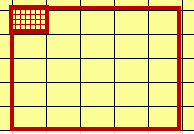

O quadrado laranja na linha 23 (tanto na horizontal como na vertical), corresponde à última posição possível para aplicar o kernel por completo, não é aplicado no exemplo devido ao stride ser igual a 3, o último elemento ocorre na linha 21. 


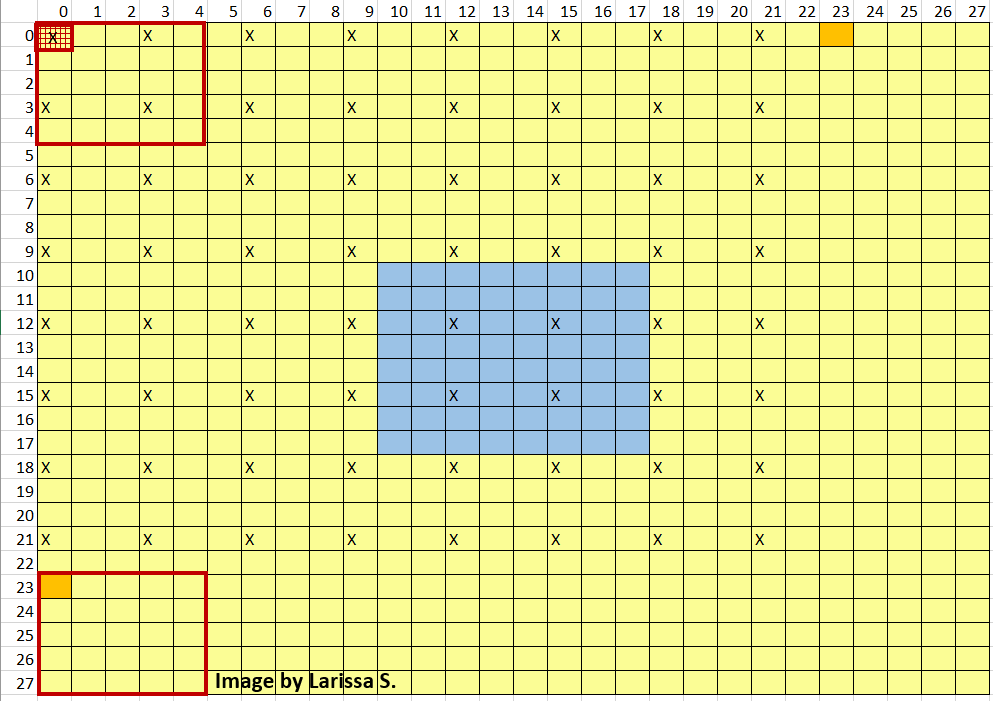

## Testes iniciais

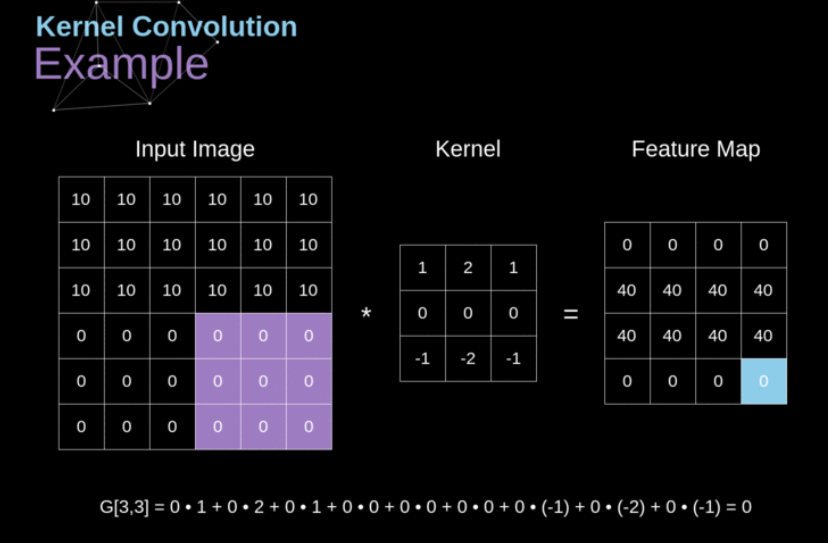

Imagem retirada do site: https://towardsdatascience.com/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9
 

### Teste 1



*   in_channels = 1
*   batch_size = 1
*   image size = 6x6
*   output_channels = 1
*   kernel_size  = 3





In [11]:
test1 = torch.tensor(np.array([[10,10,10,10,10,10],[10,10,10,10,10,10],[10,10,10,10,10,10], [0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]))
test1 = test1.float().unsqueeze(0).unsqueeze(0)
test1

tensor([[[[10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]]]])

In [12]:
test1.shape

torch.Size([1, 1, 6, 6])

In [13]:
kernel1 = torch.tensor(np.array([[1,2,1],[0,0,0],[-1,-2,-1]])).float().unsqueeze(0).unsqueeze(0)
print(kernel1.shape)
kernel1

torch.Size([1, 1, 3, 3])


tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])

In [14]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 3
stride_dummy = 1
conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
conv_layer.weight.data = torch.tensor(np.array([[1,2,1],[0,0,0],[-1,-2,-1]])).float().unsqueeze(0).unsqueeze(0)

In [15]:
out = conv_layer(test1)

input shape = torch.Size([1, 1, 6, 6])
output shape = torch.Size([1, 1, 4, 4])


In [16]:
out

tensor([[[[4.7578e-03, 4.7578e-03, 4.7578e-03, 4.7578e-03],
          [4.0005e+01, 4.0005e+01, 4.0005e+01, 4.0005e+01],
          [4.0005e+01, 4.0005e+01, 4.0005e+01, 4.0005e+01],
          [4.7578e-03, 4.7578e-03, 4.7578e-03, 4.7578e-03]]]],
       grad_fn=<CopySlices>)

In [17]:
torch.round(out, decimals=0)

tensor([[[[ 0.,  0.,  0.,  0.],
          [40., 40., 40., 40.],
          [40., 40., 40., 40.],
          [ 0.,  0.,  0.,  0.]]]], grad_fn=<RoundBackward1>)

### Teste 2



*   in_channels = 3
*   batch_size = 1
*   image size = 6x6
*   output_channels = 1
*   kernel_size = 3





In [18]:
test2 = torch.cat((test1,test1,test1), dim=1)
print(test2.shape)
test2

torch.Size([1, 3, 6, 6])


tensor([[[[10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]],

         [[10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]],

         [[10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]]]])

In [19]:
in_channels_dummy = 3
out_channels_dummy = 1
kernel_size_dummy = 3
stride_dummy = 1

#shape = [1, 5, 3, 3]
kernel = torch.tensor(np.array([[1,2,1],[0,0,0],[-1,-2,-1]])).float().unsqueeze(0).unsqueeze(0)
kernel2 = torch.cat((kernel, kernel, kernel), dim=1)
conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
conv_layer.weight.data = kernel2
initial_bias_dummy = torch.arange(out_channels_dummy,).float()
conv_layer.bias.data = initial_bias_dummy
initial_bias_dummy

tensor([0.])

In [20]:
test2.shape

torch.Size([1, 3, 6, 6])

In [21]:
kernel2.shape

torch.Size([1, 3, 3, 3])

In [22]:
out = conv_layer(test2)

input shape = torch.Size([1, 3, 6, 6])
output shape = torch.Size([1, 1, 4, 4])


In [23]:
out

tensor([[[[  0.,   0.,   0.,   0.],
          [120., 120., 120., 120.],
          [120., 120., 120., 120.],
          [  0.,   0.,   0.,   0.]]]], grad_fn=<CopySlices>)

### Teste 3



*   in_channels = 1
*   batch_size = 1
*   image size = 6x6
*   output_channels = 5





In [24]:
test3 = test1
test3

tensor([[[[10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [10., 10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.]]]])

In [25]:
in_channels_dummy = 1
out_channels_dummy = 5
kernel_size_dummy = 3
stride_dummy = 1


kernel3 = torch.tensor(np.array([[1,2,1],[0,0,0],[-1,-2,-1]])).float().unsqueeze(0).unsqueeze(0)
kernel3 = torch.cat((kernel3,kernel3,kernel3, kernel3, kernel3), dim=0)
conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
conv_layer.weight.data = kernel3

initial_bias_dummy = torch.arange(out_channels_dummy,).float()
conv_layer.bias.data = initial_bias_dummy
initial_bias_dummy

tensor([0., 1., 2., 3., 4.])

In [26]:
test3.shape

torch.Size([1, 1, 6, 6])

In [27]:
kernel3.shape

torch.Size([5, 1, 3, 3])

In [28]:
out = conv_layer(test3)

input shape = torch.Size([1, 1, 6, 6])
output shape = torch.Size([1, 5, 4, 4])


In [29]:
out

tensor([[[[ 0.,  0.,  0.,  0.],
          [40., 40., 40., 40.],
          [40., 40., 40., 40.],
          [ 0.,  0.,  0.,  0.]],

         [[ 1.,  1.,  1.,  1.],
          [41., 41., 41., 41.],
          [41., 41., 41., 41.],
          [ 1.,  1.,  1.,  1.]],

         [[ 2.,  2.,  2.,  2.],
          [42., 42., 42., 42.],
          [42., 42., 42., 42.],
          [ 2.,  2.,  2.,  2.]],

         [[ 3.,  3.,  3.,  3.],
          [43., 43., 43., 43.],
          [43., 43., 43., 43.],
          [ 3.,  3.,  3.,  3.]],

         [[ 4.,  4.,  4.,  4.],
          [44., 44., 44., 44.],
          [44., 44., 44., 44.],
          [ 4.,  4.,  4.,  4.]]]], grad_fn=<CopySlices>)

### Teste 4




*   in_channels = 3
*   batch_size = 1
*   image size = 6x6
*   output_channels = 5





In [30]:
test4 = test2
test4.shape

torch.Size([1, 3, 6, 6])

In [31]:
kernel4 = torch.cat((kernel2, kernel2, kernel2, kernel2, kernel2), dim=0)
kernel4.shape

torch.Size([5, 3, 3, 3])

In [32]:
in_channels_dummy = 3
out_channels_dummy = 5
kernel_size_dummy = 3
stride_dummy = 1


kernel4 = torch.cat((kernel2, kernel2, kernel2, kernel2, kernel2), dim=0)
conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
conv_layer.weight.data = kernel4

initial_bias_dummy = torch.arange(out_channels_dummy,).float()
conv_layer.bias.data = initial_bias_dummy
initial_bias_dummy

tensor([0., 1., 2., 3., 4.])

In [33]:
out = conv_layer(test4)

input shape = torch.Size([1, 3, 6, 6])
output shape = torch.Size([1, 5, 4, 4])


In [34]:
out

tensor([[[[  0.,   0.,   0.,   0.],
          [120., 120., 120., 120.],
          [120., 120., 120., 120.],
          [  0.,   0.,   0.,   0.]],

         [[  1.,   1.,   1.,   1.],
          [121., 121., 121., 121.],
          [121., 121., 121., 121.],
          [  1.,   1.,   1.,   1.]],

         [[  2.,   2.,   2.,   2.],
          [122., 122., 122., 122.],
          [122., 122., 122., 122.],
          [  2.,   2.,   2.,   2.]],

         [[  3.,   3.,   3.,   3.],
          [123., 123., 123., 123.],
          [123., 123., 123., 123.],
          [  3.,   3.,   3.,   3.]],

         [[  4.,   4.,   4.,   4.],
          [124., 124., 124., 124.],
          [124., 124., 124., 124.],
          [  4.,   4.,   4.,   4.]]]], grad_fn=<CopySlices>)

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [35]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

input shape = torch.Size([1, 1, 5, 6])
output shape = torch.Size([1, 1, 4, 5])


In [36]:
conv_layer.weight

Parameter containing:
tensor([[[[0., 1.],
          [2., 3.]]]], requires_grad=True)

In [37]:
out

tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]], grad_fn=<CopySlices>)

In [38]:
target_out

tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]], grad_fn=<ConvolutionBackward0>)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [39]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

input shape = torch.Size([2, 1, 28, 28])
output shape = torch.Size([2, 2, 8, 8])


In [40]:
out

tensor([[[[-0.0230, -0.0167, -0.0122, -0.0071, -0.0090, -0.0312, -0.0055,
           -0.0150],
          [-0.0078, -0.0063, -0.0177, -0.0081, -0.0003, -0.0080, -0.0196,
            0.0026],
          [-0.0102, -0.0154,  0.0071, -0.0097, -0.0147, -0.0060, -0.0176,
           -0.0036],
          [-0.0017, -0.0026, -0.0039,  0.0055,  0.0137, -0.0227, -0.0053,
           -0.0149],
          [-0.0050, -0.0115, -0.0271, -0.0143, -0.0044, -0.0021, -0.0025,
           -0.0124],
          [-0.0186, -0.0130, -0.0046, -0.0142, -0.0095, -0.0252, -0.0020,
           -0.0089],
          [ 0.0018, -0.0161, -0.0007,  0.0034,  0.0015, -0.0060, -0.0260,
           -0.0184],
          [-0.0054, -0.0087, -0.0074, -0.0101, -0.0035, -0.0093, -0.0025,
           -0.0096]],

         [[ 0.0276,  0.0098,  0.0172,  0.0105, -0.0040,  0.0101,  0.0145,
            0.0235],
          [ 0.0031,  0.0291,  0.0216,  0.0180,  0.0206,  0.0244,  0.0174,
            0.0092],
          [ 0.0167,  0.0360,  0.0227,  0.0157,  

In [41]:
out.shape

torch.Size([2, 2, 8, 8])

In [42]:
target_out.shape

torch.Size([2, 2, 8, 8])

In [43]:
target_out

tensor([[[[-0.0230, -0.0167, -0.0122, -0.0071, -0.0090, -0.0312, -0.0055,
           -0.0150],
          [-0.0078, -0.0063, -0.0177, -0.0081, -0.0003, -0.0080, -0.0196,
            0.0026],
          [-0.0102, -0.0154,  0.0071, -0.0097, -0.0147, -0.0060, -0.0176,
           -0.0036],
          [-0.0017, -0.0026, -0.0039,  0.0055,  0.0137, -0.0227, -0.0053,
           -0.0149],
          [-0.0050, -0.0115, -0.0271, -0.0143, -0.0044, -0.0021, -0.0025,
           -0.0124],
          [-0.0186, -0.0130, -0.0046, -0.0142, -0.0095, -0.0252, -0.0020,
           -0.0089],
          [ 0.0018, -0.0161, -0.0007,  0.0034,  0.0015, -0.0060, -0.0260,
           -0.0184],
          [-0.0054, -0.0087, -0.0074, -0.0101, -0.0035, -0.0093, -0.0025,
           -0.0096]],

         [[ 0.0276,  0.0098,  0.0172,  0.0105, -0.0040,  0.0101,  0.0145,
            0.0235],
          [ 0.0031,  0.0291,  0.0216,  0.0180,  0.0206,  0.0244,  0.0174,
            0.0092],
          [ 0.0167,  0.0360,  0.0227,  0.0157,  

## Modelo

In [44]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [45]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [46]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
input shape = torch.Size([50, 1, 28, 28])
output shape = torch.Size([50, 2, 8, 8])
inpu

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

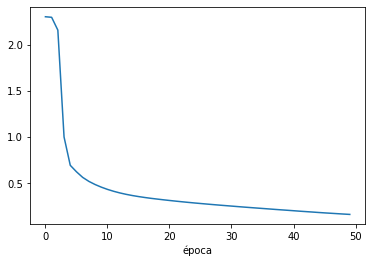

In [47]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [48]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923893451690674,
 0.5867354869842529,
 0.5144088864326477,
 0.4502663314342499,
 0.4075140655040741,
 0.37713873386383057,
 0.3534485995769501,
 0.3341451585292816,
 0.3181140422821045,
 0.30457887053489685,
 0.2928348779678345,
 0.2827608287334442,
 0.2738332748413086,
 0.26577427983283997,
 0.2583288252353668,
 0.25117501616477966,
 0.24439716339111328,
 0.2378995716571808,
 0.23167717456817627,
 0.22562651336193085,
 0.21984528005123138,
 0.21429124474525452,
 0.20894214510917664,
 0.2038729339838028,
 0.19903428852558136,
 0.19439975917339325,
 0.18994098901748657,
 0.18564006686210632,
 0.18147487938404083,
 0.1774490773677826,
 0.1734725534915924,
 0.1694747507572174,
 0.16547326743602753,
 0.1615050882101059,
 0.15746401250362396,
 0.15340447425842285,
 0.14926907420158386,
 0.14520640671253204,
 0.1412365883588791,
 0.13712678849697113,
 0.1331038475036621,
 0.12914668023586273,
 0.12515045702457428,
 0.1211676225066185,
 0.1173172593

In [49]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)